In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
learning_rate=0.0001
batch_size=50
num_epochs=10
num_classes=10

In [4]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5))])

In [5]:
train_dataset=torchvision.datasets.FashionMNIST(root='./data',train=True,download=True,transform=transform)
test_dataset=torchvision.datasets.FashionMNIST(root='./data',train=False,download=True,transform=transform)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.3MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.83MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.6MB/s]


In [6]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

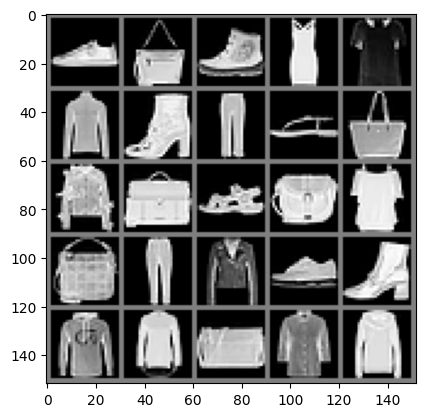

In [7]:
classes=('T-shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')

def imshow(imgs):
  imgs=imgs/2+0.5
  npimgs=imgs.numpy()
  plt.imshow(np.transpose(npimgs,(1,2,0)))
  plt.show()

dataiter=iter(train_loader)
images,labels=next(dataiter)
img_grid=torchvision.utils.make_grid(images[0:25],nrow=5)
imshow(img_grid)

In [8]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(1,32,3,padding=1)
    self.conv2=nn.Conv2d(32,64,3,padding=1)
    self.conv3=nn.Conv2d(64,128,3,padding=1)
    self.conv4=nn.Conv2d(128,256,3,padding=1)
    self.pool=nn.MaxPool2d(2,2)
    self.fc1=nn.Linear(256*3*3,1024)
    self.fc2=nn.Linear(1024,512)
    self.fc3=nn.Linear(512,10)

  def forward(self,x):
    #N,1,28,28
    x=F.relu(self.conv1(x)) #N,32,28,28
    x=self.pool(x) #N,32,14,14
    x=F.relu(self.conv2(x)) #N,64,14,14
    x=self.pool(x) #N,64,7,7
    x=F.relu(self.conv3(x)) #N,128,7,7
    x=self.pool(x) #N,128,3,3
    x=F.relu(self.conv4(x)) #N,256,3,3
    x=torch.flatten(x,1) #N,256*3*3
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x

In [9]:
model=ConvNN().to(device)

In [10]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [11]:
n_total_steps=len(train_loader)
for epoch in range(num_epochs):
  running_loss=0.0
  for i,(images,labels) in enumerate(train_loader):
    images=images.to(device)
    labels=labels.to(device)

    outputs=model(images)
    loss=criterion(outputs,labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    running_loss+=loss.item()

  print(f'Epoch:[{epoch+1}], Loss:{running_loss/n_total_steps:.3f}')

Epoch:[1], Loss:0.668
Epoch:[2], Loss:0.410
Epoch:[3], Loss:0.337
Epoch:[4], Loss:0.295
Epoch:[5], Loss:0.265
Epoch:[6], Loss:0.244
Epoch:[7], Loss:0.225
Epoch:[8], Loss:0.209
Epoch:[9], Loss:0.194
Epoch:[10], Loss:0.182


In [12]:
with torch.no_grad():
  n_correct=0
  n_samples=len(test_loader.dataset)

  for images,labels in test_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)

    _,predicted=torch.max(outputs,1)
    n_correct+=(predicted==labels).sum().item()

  acc=100*n_correct/n_samples
  print(f'Accuracy of the model is {acc}%')

Accuracy of the model is 91.33%
